In [27]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from bayes_opt import BayesianOptimization
from sklearn.decomposition import PCA
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import StratifiedKFold
import time
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import warnings
warnings.filterwarnings('ignore')

In [28]:
cols = ["HomePlanet", "CryoSleep", "Destination", "Age", "VIP", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Deck_Cabin", "Side_Cabin"]
labelCols = ["HomePlanet", "CryoSleep", "Destination", "VIP", "Deck_Cabin", "Side_Cabin"]
numericalCols = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
def preprocessingData(data):
    """
    The PassengerId and Name features don't provide any useful information that can help us predict the 
    Transported feature. The Cabin feature takes the form Deck/Num/Side. The Num part isn't too relevant 
    but the Deck and Side parts might be useful in predicting the Transported feature.
    """
    cabinSplit = data['Cabin'].str.split("/", expand=True)
    data['Deck_Cabin'] = cabinSplit[0]
    data['Side_Cabin'] = cabinSplit[2]
    data = data.drop(columns=["PassengerId", "Name", "Cabin"])
    
    """
    Transforming the categorical columns with one hot encoding to ensure that there's no hierarchy 
    between the different categories in each column
    """
    onehotencoder = OneHotEncoder()
    for col in labelCols:
        data[col] = data[col].astype(str)
        X = onehotencoder.fit_transform(data[col].values.reshape(-1, 1)).toarray()
        dfOneHot = pd.DataFrame(X) 
        listValues = list(data[col].unique())
        listValues.remove("nan")
        for i in range(len(listValues)):
            for column in dfOneHot:
                if dfOneHot[column].sum() == (data[col] == listValues[i]).sum():
                    data[col + "_" + str(listValues[i])] = dfOneHot[column]
        data = data.drop(columns=[col])
    
    #Filling the nan values in every numerical feature except Age with the mode value
    #Filling the nan values in the Age feature with the mean value
    #Standardizing the numerical columns so that all the values in these columns are on the same numerical scale
    for col in numericalCols:
        if col == "Age":
            data[col] = data[col].fillna(data[col].mean())
        else:
            data[col] = data[col].fillna(data[col].mode()[0])
        data[col] = (data[col] - data[col].mean())/(data[col].std())
    
    return data

[0.18723247 0.3205003  0.42918079 0.5311294  0.62715679 0.71217121
 0.76835846 0.8221937  0.86684426 0.90191784 0.92687558 0.94388589
 0.95571319 0.9667193  0.97649804 0.98276294 0.98856729 0.99275188
 0.99467812 0.9960491  0.99738318 0.99836153 0.99917469 0.99992833
 1.         1.        ]


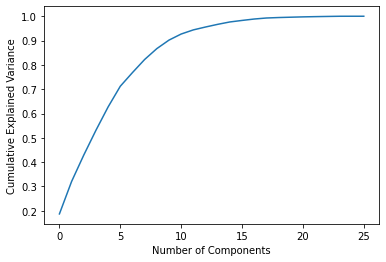

In [29]:
data = pd.read_csv("train.csv")
data = preprocessingData(data)
X = data.drop(columns=["Transported"])
y = data["Transported"]

#Conducting PCA to see if we can reduce the number of dimensions in the dataset. 
pca = PCA()
XPca = pca.fit_transform(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

"""
After just 13 principal components more than 95% of the explained variance is covered by the newly
transformed XPca dataset according to the output and plot generated below. We'll still try including 
the further principal components in the XPca dataset to see exactly how many dimensions are required 
in our training dataset to produce the greatest accuracy.
"""
print(np.cumsum(pca.explained_variance_ratio_))

In [30]:
"""
The following code tunes the most influential Neural Networks hyperparameters (activation, batch_size, 
epochs, learning_rate, neurons, and optimizer) along with the configuration for the layers at the same 
time. I chose to incorporate two sets of layers where each set is between 1 and 3 layers. After the first 
hidden layer I chose to optionally add a batch normalization layer which normalizes the values that are 
passed to it for every batch. After the first set of layers is added to the neural networks model, I chose to
optionally add a dropout layer which randomly drops a certain number of neurons in a layer. The rate of how 
much percentage of neurons get dropped is set in the dropout_rate variable.
"""

'\nThe following code tunes the most influential Neural Networks hyperparameters (activation, batch_size, \nepochs, learning_rate, neurons, and optimizer) along with the configuration for the layers at the same \ntime. I chose to incorporate two sets of layers where each set is between 1 and 3 layers. After the first \nhidden layer I chose to optionally add a batch normalization layer which normalizes the values that are \npassed to it for every batch. After the first set of layers is added to the neural networks model, I chose to\noptionally add a dropout layer which randomly drops a certain number of neurons in a layer. The rate of how \nmuch percentage of neurons get dropped is set in the dropout_rate variable.\n'

In [31]:
#Using Bayesian Optimization to tune the hyperparameters
max_score = (0, {})
def generateNN(neurons, dim, activation, normalization, layers1, dropout, dropout_rate, layers2, optimizer):
    model = Sequential()
    model.add(Dense(neurons, input_dim=dim, activation=activation))
    if normalization > 0.5:
        model.add(BatchNormalization())
    for i in range(layers1):
        model.add(Dense(neurons, activation=activation))
    if dropout > 0.5:
        model.add(Dropout(dropout_rate, seed=0))
    for i in range(layers2):
        model.add(Dense(neurons, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

def score(neurons, activation, optimizer, learning_rate, batch_size, epochs,
              layers1, layers2, normalization, dropout, dropout_rate):
    optimizers = [Adam(learning_rate), SGD(learning_rate), RMSprop(learning_rate), Adadelta(learning_rate), 
              Adagrad(learning_rate), Adamax(learning_rate), Nadam(learning_rate), Ftrl(learning_rate)]
    activations = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu', 'elu', 'exponential']
    
    neurons = round(neurons)
    activation = activations[round(activation)]
    optimizer = optimizers[round(optimizer)]
    batch_size = round(batch_size)
    epochs = round(epochs)
    layers1 = round(layers1)
    layers2 = round(layers2)
    
    def generateModel():
        return generateNN(neurons, len(X[0]), activation, normalization, layers1, dropout, 
                        dropout_rate, layers2, optimizer)
    
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
    nn = KerasClassifier(build_fn=generateModel, epochs=epochs, batch_size=batch_size, verbose=0)
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    scores = cross_val_score(nn, X, y, scoring="accuracy", cv=kfold, fit_params={'callbacks':[es]})
    scores = scores[~np.isnan(scores)]
    mean_acc = scores.mean()
    global max_score
    if mean_acc > max_score[0]:
        max_score = (mean_acc, {
            'neurons': neurons,
            'activation': activation,
            'optimizer': optimizer,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'epochs': epochs,
            'layers1': layers1,
            'layers2': layers2,
            'normalization': normalization,
            'dropout': dropout,
            'dropout_rate': dropout_rate
        })
    return mean_acc

hyperparams = {
    'neurons': (10, 100),
    'activation': (0, 7),
    'optimizer': (0,7),
    'learning_rate': (0.01, 1),
    'batch_size': (200, 1000),
    'epochs': (20, 100),
    'layers1': (1,3),
    'layers2': (1,3),
    'normalization': (0,1),
    'dropout': (0,1),
    'dropout_rate': (0,0.3)
}

start = time.time()
for dim in range(13, 27):
    X = XPca[:, :dim]
    print("Running Bayesian Optimization on the Training Dataset With " + str(dim) + " Dimensions")
    bo = BayesianOptimization(score, hyperparams, random_state=1)
    bo.maximize(init_points=50, n_iter=10)
    print(str(dim) + " Dimensions Best Accuracy: %f using %s" % (max_score[0], str(max_score[1])))
    max_score = (0, {})
    print()
end = time.time()
elapsedTime = end - start
print("Elapsed Time: " + str(elapsedTime) + " seconds")

Running Bayesian Optimization on the Training Dataset With 13 Dimensions
|   iter    |  target   | activa... | batch_... |  dropout  | dropou... |  epochs   |  layers1  |  layers2  | learni... |  neurons  | normal... | optimizer |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.7931    | 2.919     | 776.3     | 0.0001144 | 0.0907    | 31.74     | 1.185     | 1.373     | 0.3521    | 45.71     | 0.5388    | 2.934     |
| 2         | 0.7908    | 4.797     | 363.6     | 0.8781    | 0.008216  | 73.64     | 1.835     | 2.117     | 0.149     | 27.83     | 0.8007    | 6.778     |
| 3         | 0.777     | 2.194     | 753.9     | 0.8764    | 0.2684    | 26.8      | 1.078     | 1.34      | 0.8794    | 18.85     | 0.4211    | 6.705     |
| 4         | 0.5287    | 3.732     | 753.5     | 0.3155    | 0.206     | 86.77     | 1.037     | 2.5       | 0.989     | 77.33     | 0.2

| 31        | 0.4966    | 1.012     | 801.2     | 0.222     | 0.1558    | 82.82     | 1.045     | 1.649     | 0.8742    | 86.02     | 0.5384    | 6.066     |
| 32        | 0.4966    | 6.649     | 861.1     | 0.8541    | 0.02962   | 72.1      | 2.407     | 2.22      | 0.8016    | 13.11     | 0.7702    | 5.122     |
| 33        | 0.5034    | 1.818     | 405.7     | 0.6323    | 0.1036    | 83.73     | 1.892     | 2.565     | 0.9906    | 37.02     | 0.143     | 6.309     |
| 34        | 0.808     | 3.791     | 979.8     | 0.6366    | 0.2982    | 63.69     | 2.053     | 1.271     | 0.3621    | 12.36     | 0.1604    | 5.219     |
| 35        | 0.5034    | 0.2128    | 493.2     | 0.8623    | 0.2078    | 75.28     | 1.377     | 1.884     | 0.5858    | 99.08     | 0.2039    | 1.734     |
| 36        | 0.7977    | 1.835     | 800.1     | 0.457     | 0.01708   | 60.68     | 1.424     | 2.597     | 0.3044    | 12.48     | 0.5934    | 5.907     |
| 37        | 0.5034    | 2.667     | 799.9     | 0.

| 1         | 0.8       | 2.919     | 776.3     | 0.0001144 | 0.0907    | 31.74     | 1.185     | 1.373     | 0.3521    | 45.71     | 0.5388    | 2.934     |
| 2         | 0.5034    | 4.797     | 363.6     | 0.8781    | 0.008216  | 73.64     | 1.835     | 2.117     | 0.149     | 27.83     | 0.8007    | 6.778     |
| 3         | 0.7805    | 2.194     | 753.9     | 0.8764    | 0.2684    | 26.8      | 1.078     | 1.34      | 0.8794    | 18.85     | 0.4211    | 6.705     |
| 4         | 0.6506    | 3.732     | 753.5     | 0.3155    | 0.206     | 86.77     | 1.037     | 2.5       | 0.989     | 77.33     | 0.2804    | 5.525     |
| 5         | 0.7667    | 0.7226    | 558.3     | 0.9086    | 0.08808   | 43.02     | 1.26      | 1.039     | 0.682     | 29.05     | 0.2655    | 3.441     |
| 6         | 0.7839    | 0.3735    | 659.3     | 0.1467    | 0.1768    | 75.98     | 1.205     | 1.828     | 0.6975    | 47.28     | 0.04995   | 3.751     |
| 7         | 0.4966    | 4.647     | 611.9     | 0.

| 33        | 0.5034    | 1.818     | 405.7     | 0.6323    | 0.1036    | 83.73     | 1.892     | 2.565     | 0.9906    | 37.02     | 0.143     | 6.309     |
| 34        | 0.7954    | 3.791     | 979.8     | 0.6366    | 0.2982    | 63.69     | 2.053     | 1.271     | 0.3621    | 12.36     | 0.1604    | 5.219     |
| 35        | 0.4966    | 0.2128    | 493.2     | 0.8623    | 0.2078    | 75.28     | 1.377     | 1.884     | 0.5858    | 99.08     | 0.2039    | 1.734     |
| 36        | 0.7954    | 1.835     | 800.1     | 0.457     | 0.01708   | 60.68     | 1.424     | 2.597     | 0.3044    | 12.48     | 0.5934    | 5.907     |
| 37        | 0.5034    | 2.667     | 799.9     | 0.5111    | 0.1623    | 96.75     | 2.608     | 1.065     | 0.7123    | 51.85     | 0.9475    | 1.55      |
| 38        | 0.8092    | 1.87      | 265.2     | 0.4286    | 0.03271   | 70.7      | 2.606     | 2.394     | 0.7685    | 40.82     | 0.8459    | 3.001     |
| 39        | 0.746     | 5.768     | 701.2     | 0.

| 1         | 0.7954    | 2.919     | 776.3     | 0.0001144 | 0.0907    | 31.74     | 1.185     | 1.373     | 0.3521    | 45.71     | 0.5388    | 2.934     |
| 2         | 0.5034    | 4.797     | 363.6     | 0.8781    | 0.008216  | 73.64     | 1.835     | 2.117     | 0.149     | 27.83     | 0.8007    | 6.778     |
| 3         | 0.7851    | 2.194     | 753.9     | 0.8764    | 0.2684    | 26.8      | 1.078     | 1.34      | 0.8794    | 18.85     | 0.4211    | 6.705     |
| 4         | 0.6       | 3.732     | 753.5     | 0.3155    | 0.206     | 86.77     | 1.037     | 2.5       | 0.989     | 77.33     | 0.2804    | 5.525     |
| 5         | 0.7747    | 0.7226    | 558.3     | 0.9086    | 0.08808   | 43.02     | 1.26      | 1.039     | 0.682     | 29.05     | 0.2655    | 3.441     |
| 6         | 0.7966    | 0.3735    | 659.3     | 0.1467    | 0.1768    | 75.98     | 1.205     | 1.828     | 0.6975    | 47.28     | 0.04995   | 3.751     |
| 7         | 0.4966    | 4.647     | 611.9     | 0.

| 33        | 0.7621    | 1.818     | 405.7     | 0.6323    | 0.1036    | 83.73     | 1.892     | 2.565     | 0.9906    | 37.02     | 0.143     | 6.309     |
| 34        | 0.7954    | 3.791     | 979.8     | 0.6366    | 0.2982    | 63.69     | 2.053     | 1.271     | 0.3621    | 12.36     | 0.1604    | 5.219     |
| 35        | 0.5034    | 0.2128    | 493.2     | 0.8623    | 0.2078    | 75.28     | 1.377     | 1.884     | 0.5858    | 99.08     | 0.2039    | 1.734     |
| 36        | 0.5034    | 1.835     | 800.1     | 0.457     | 0.01708   | 60.68     | 1.424     | 2.597     | 0.3044    | 12.48     | 0.5934    | 5.907     |
| 37        | 0.4966    | 2.667     | 799.9     | 0.5111    | 0.1623    | 96.75     | 2.608     | 1.065     | 0.7123    | 51.85     | 0.9475    | 1.55      |
| 38        | 0.7966    | 1.87      | 265.2     | 0.4286    | 0.03271   | 70.7      | 2.606     | 2.394     | 0.7685    | 40.82     | 0.8459    | 3.001     |
| 39        | 0.7563    | 5.768     | 701.2     | 0.

| 1         | 0.8023    | 2.919     | 776.3     | 0.0001144 | 0.0907    | 31.74     | 1.185     | 1.373     | 0.3521    | 45.71     | 0.5388    | 2.934     |
| 2         | 0.5034    | 4.797     | 363.6     | 0.8781    | 0.008216  | 73.64     | 1.835     | 2.117     | 0.149     | 27.83     | 0.8007    | 6.778     |
| 3         | 0.7954    | 2.194     | 753.9     | 0.8764    | 0.2684    | 26.8      | 1.078     | 1.34      | 0.8794    | 18.85     | 0.4211    | 6.705     |
| 4         | 0.5483    | 3.732     | 753.5     | 0.3155    | 0.206     | 86.77     | 1.037     | 2.5       | 0.989     | 77.33     | 0.2804    | 5.525     |
| 5         | 0.7747    | 0.7226    | 558.3     | 0.9086    | 0.08808   | 43.02     | 1.26      | 1.039     | 0.682     | 29.05     | 0.2655    | 3.441     |
| 6         | 0.8       | 0.3735    | 659.3     | 0.1467    | 0.1768    | 75.98     | 1.205     | 1.828     | 0.6975    | 47.28     | 0.04995   | 3.751     |
| 7         | 0.508     | 4.647     | 611.9     | 0.

| 33        | 0.7207    | 1.818     | 405.7     | 0.6323    | 0.1036    | 83.73     | 1.892     | 2.565     | 0.9906    | 37.02     | 0.143     | 6.309     |
| 34        | 0.7885    | 3.791     | 979.8     | 0.6366    | 0.2982    | 63.69     | 2.053     | 1.271     | 0.3621    | 12.36     | 0.1604    | 5.219     |
| 35        | 0.4966    | 0.2128    | 493.2     | 0.8623    | 0.2078    | 75.28     | 1.377     | 1.884     | 0.5858    | 99.08     | 0.2039    | 1.734     |
| 36        | 0.8011    | 1.835     | 800.1     | 0.457     | 0.01708   | 60.68     | 1.424     | 2.597     | 0.3044    | 12.48     | 0.5934    | 5.907     |
| 37        | 0.6529    | 2.667     | 799.9     | 0.5111    | 0.1623    | 96.75     | 2.608     | 1.065     | 0.7123    | 51.85     | 0.9475    | 1.55      |
| 38        | 0.8046    | 1.87      | 265.2     | 0.4286    | 0.03271   | 70.7      | 2.606     | 2.394     | 0.7685    | 40.82     | 0.8459    | 3.001     |
| 39        | 0.7115    | 5.768     | 701.2     | 0.

| 1         | 0.8034    | 2.919     | 776.3     | 0.0001144 | 0.0907    | 31.74     | 1.185     | 1.373     | 0.3521    | 45.71     | 0.5388    | 2.934     |
| 2         | 0.5034    | 4.797     | 363.6     | 0.8781    | 0.008216  | 73.64     | 1.835     | 2.117     | 0.149     | 27.83     | 0.8007    | 6.778     |
| 3         | 0.7828    | 2.194     | 753.9     | 0.8764    | 0.2684    | 26.8      | 1.078     | 1.34      | 0.8794    | 18.85     | 0.4211    | 6.705     |
| 4         | 0.5034    | 3.732     | 753.5     | 0.3155    | 0.206     | 86.77     | 1.037     | 2.5       | 0.989     | 77.33     | 0.2804    | 5.525     |
| 5         | 0.7759    | 0.7226    | 558.3     | 0.9086    | 0.08808   | 43.02     | 1.26      | 1.039     | 0.682     | 29.05     | 0.2655    | 3.441     |
| 6         | 0.7713    | 0.3735    | 659.3     | 0.1467    | 0.1768    | 75.98     | 1.205     | 1.828     | 0.6975    | 47.28     | 0.04995   | 3.751     |
| 7         | 0.5034    | 4.647     | 611.9     | 0.

| 33        | 0.5034    | 1.818     | 405.7     | 0.6323    | 0.1036    | 83.73     | 1.892     | 2.565     | 0.9906    | 37.02     | 0.143     | 6.309     |
| 34        | 0.7816    | 3.791     | 979.8     | 0.6366    | 0.2982    | 63.69     | 2.053     | 1.271     | 0.3621    | 12.36     | 0.1604    | 5.219     |
| 35        | 0.5034    | 0.2128    | 493.2     | 0.8623    | 0.2078    | 75.28     | 1.377     | 1.884     | 0.5858    | 99.08     | 0.2039    | 1.734     |
| 36        | 0.7736    | 1.835     | 800.1     | 0.457     | 0.01708   | 60.68     | 1.424     | 2.597     | 0.3044    | 12.48     | 0.5934    | 5.907     |
| 37        | 0.5034    | 2.667     | 799.9     | 0.5111    | 0.1623    | 96.75     | 2.608     | 1.065     | 0.7123    | 51.85     | 0.9475    | 1.55      |
| 38        | 0.8057    | 1.87      | 265.2     | 0.4286    | 0.03271   | 70.7      | 2.606     | 2.394     | 0.7685    | 40.82     | 0.8459    | 3.001     |
| 39        | 0.7483    | 5.768     | 701.2     | 0.

| 1         | 0.8057    | 2.919     | 776.3     | 0.0001144 | 0.0907    | 31.74     | 1.185     | 1.373     | 0.3521    | 45.71     | 0.5388    | 2.934     |
| 2         | 0.8       | 4.797     | 363.6     | 0.8781    | 0.008216  | 73.64     | 1.835     | 2.117     | 0.149     | 27.83     | 0.8007    | 6.778     |
| 3         | 0.7736    | 2.194     | 753.9     | 0.8764    | 0.2684    | 26.8      | 1.078     | 1.34      | 0.8794    | 18.85     | 0.4211    | 6.705     |
| 4         | 0.692     | 3.732     | 753.5     | 0.3155    | 0.206     | 86.77     | 1.037     | 2.5       | 0.989     | 77.33     | 0.2804    | 5.525     |
| 5         | 0.7736    | 0.7226    | 558.3     | 0.9086    | 0.08808   | 43.02     | 1.26      | 1.039     | 0.682     | 29.05     | 0.2655    | 3.441     |
| 6         | 0.8       | 0.3735    | 659.3     | 0.1467    | 0.1768    | 75.98     | 1.205     | 1.828     | 0.6975    | 47.28     | 0.04995   | 3.751     |
| 7         | 0.4966    | 4.647     | 611.9     | 0.

| 33        | 0.4966    | 1.818     | 405.7     | 0.6323    | 0.1036    | 83.73     | 1.892     | 2.565     | 0.9906    | 37.02     | 0.143     | 6.309     |
| 34        | 0.7977    | 3.791     | 979.8     | 0.6366    | 0.2982    | 63.69     | 2.053     | 1.271     | 0.3621    | 12.36     | 0.1604    | 5.219     |
| 35        | 0.5034    | 0.2128    | 493.2     | 0.8623    | 0.2078    | 75.28     | 1.377     | 1.884     | 0.5858    | 99.08     | 0.2039    | 1.734     |
| 36        | 0.7379    | 1.835     | 800.1     | 0.457     | 0.01708   | 60.68     | 1.424     | 2.597     | 0.3044    | 12.48     | 0.5934    | 5.907     |
| 37        | 0.4966    | 2.667     | 799.9     | 0.5111    | 0.1623    | 96.75     | 2.608     | 1.065     | 0.7123    | 51.85     | 0.9475    | 1.55      |
| 38        | 0.7839    | 1.87      | 265.2     | 0.4286    | 0.03271   | 70.7      | 2.606     | 2.394     | 0.7685    | 40.82     | 0.8459    | 3.001     |
| 39        | 0.7609    | 5.768     | 701.2     | 0.

| 1         | 0.792     | 2.919     | 776.3     | 0.0001144 | 0.0907    | 31.74     | 1.185     | 1.373     | 0.3521    | 45.71     | 0.5388    | 2.934     |
| 2         | 0.8126    | 4.797     | 363.6     | 0.8781    | 0.008216  | 73.64     | 1.835     | 2.117     | 0.149     | 27.83     | 0.8007    | 6.778     |
| 3         | 0.7908    | 2.194     | 753.9     | 0.8764    | 0.2684    | 26.8      | 1.078     | 1.34      | 0.8794    | 18.85     | 0.4211    | 6.705     |
| 4         | 0.6621    | 3.732     | 753.5     | 0.3155    | 0.206     | 86.77     | 1.037     | 2.5       | 0.989     | 77.33     | 0.2804    | 5.525     |
| 5         | 0.7713    | 0.7226    | 558.3     | 0.9086    | 0.08808   | 43.02     | 1.26      | 1.039     | 0.682     | 29.05     | 0.2655    | 3.441     |
| 6         | 0.7874    | 0.3735    | 659.3     | 0.1467    | 0.1768    | 75.98     | 1.205     | 1.828     | 0.6975    | 47.28     | 0.04995   | 3.751     |
| 7         | 0.5034    | 4.647     | 611.9     | 0.

| 33        | 0.4966    | 1.818     | 405.7     | 0.6323    | 0.1036    | 83.73     | 1.892     | 2.565     | 0.9906    | 37.02     | 0.143     | 6.309     |
| 34        | 0.7977    | 3.791     | 979.8     | 0.6366    | 0.2982    | 63.69     | 2.053     | 1.271     | 0.3621    | 12.36     | 0.1604    | 5.219     |
| 35        | 0.5034    | 0.2128    | 493.2     | 0.8623    | 0.2078    | 75.28     | 1.377     | 1.884     | 0.5858    | 99.08     | 0.2039    | 1.734     |
| 36        | 0.777     | 1.835     | 800.1     | 0.457     | 0.01708   | 60.68     | 1.424     | 2.597     | 0.3044    | 12.48     | 0.5934    | 5.907     |
| 37        | 0.6759    | 2.667     | 799.9     | 0.5111    | 0.1623    | 96.75     | 2.608     | 1.065     | 0.7123    | 51.85     | 0.9475    | 1.55      |
| 38        | 0.7931    | 1.87      | 265.2     | 0.4286    | 0.03271   | 70.7      | 2.606     | 2.394     | 0.7685    | 40.82     | 0.8459    | 3.001     |
| 39        | 0.7069    | 5.768     | 701.2     | 0.

| 1         | 0.8057    | 2.919     | 776.3     | 0.0001144 | 0.0907    | 31.74     | 1.185     | 1.373     | 0.3521    | 45.71     | 0.5388    | 2.934     |
| 2         | 0.5034    | 4.797     | 363.6     | 0.8781    | 0.008216  | 73.64     | 1.835     | 2.117     | 0.149     | 27.83     | 0.8007    | 6.778     |
| 3         | 0.7966    | 2.194     | 753.9     | 0.8764    | 0.2684    | 26.8      | 1.078     | 1.34      | 0.8794    | 18.85     | 0.4211    | 6.705     |
| 4         | 0.6644    | 3.732     | 753.5     | 0.3155    | 0.206     | 86.77     | 1.037     | 2.5       | 0.989     | 77.33     | 0.2804    | 5.525     |
| 5         | 0.7632    | 0.7226    | 558.3     | 0.9086    | 0.08808   | 43.02     | 1.26      | 1.039     | 0.682     | 29.05     | 0.2655    | 3.441     |
| 6         | 0.7908    | 0.3735    | 659.3     | 0.1467    | 0.1768    | 75.98     | 1.205     | 1.828     | 0.6975    | 47.28     | 0.04995   | 3.751     |
| 7         | 0.5034    | 4.647     | 611.9     | 0.

| 33        | 0.4966    | 1.818     | 405.7     | 0.6323    | 0.1036    | 83.73     | 1.892     | 2.565     | 0.9906    | 37.02     | 0.143     | 6.309     |
| 34        | 0.7908    | 3.791     | 979.8     | 0.6366    | 0.2982    | 63.69     | 2.053     | 1.271     | 0.3621    | 12.36     | 0.1604    | 5.219     |
| 35        | 0.4966    | 0.2128    | 493.2     | 0.8623    | 0.2078    | 75.28     | 1.377     | 1.884     | 0.5858    | 99.08     | 0.2039    | 1.734     |
| 36        | 0.7713    | 1.835     | 800.1     | 0.457     | 0.01708   | 60.68     | 1.424     | 2.597     | 0.3044    | 12.48     | 0.5934    | 5.907     |
| 37        | 0.5034    | 2.667     | 799.9     | 0.5111    | 0.1623    | 96.75     | 2.608     | 1.065     | 0.7123    | 51.85     | 0.9475    | 1.55      |
| 38        | 0.8011    | 1.87      | 265.2     | 0.4286    | 0.03271   | 70.7      | 2.606     | 2.394     | 0.7685    | 40.82     | 0.8459    | 3.001     |
| 39        | 0.7667    | 5.768     | 701.2     | 0.

| 1         | 0.7885    | 2.919     | 776.3     | 0.0001144 | 0.0907    | 31.74     | 1.185     | 1.373     | 0.3521    | 45.71     | 0.5388    | 2.934     |
| 2         | 0.5034    | 4.797     | 363.6     | 0.8781    | 0.008216  | 73.64     | 1.835     | 2.117     | 0.149     | 27.83     | 0.8007    | 6.778     |
| 3         | 0.792     | 2.194     | 753.9     | 0.8764    | 0.2684    | 26.8      | 1.078     | 1.34      | 0.8794    | 18.85     | 0.4211    | 6.705     |
| 4         | 0.6747    | 3.732     | 753.5     | 0.3155    | 0.206     | 86.77     | 1.037     | 2.5       | 0.989     | 77.33     | 0.2804    | 5.525     |
| 5         | 0.7552    | 0.7226    | 558.3     | 0.9086    | 0.08808   | 43.02     | 1.26      | 1.039     | 0.682     | 29.05     | 0.2655    | 3.441     |
| 6         | 0.7943    | 0.3735    | 659.3     | 0.1467    | 0.1768    | 75.98     | 1.205     | 1.828     | 0.6975    | 47.28     | 0.04995   | 3.751     |
| 7         | 0.4966    | 4.647     | 611.9     | 0.

| 33        | 0.5368    | 1.818     | 405.7     | 0.6323    | 0.1036    | 83.73     | 1.892     | 2.565     | 0.9906    | 37.02     | 0.143     | 6.309     |
| 34        | 0.7954    | 3.791     | 979.8     | 0.6366    | 0.2982    | 63.69     | 2.053     | 1.271     | 0.3621    | 12.36     | 0.1604    | 5.219     |
| 35        | 0.4966    | 0.2128    | 493.2     | 0.8623    | 0.2078    | 75.28     | 1.377     | 1.884     | 0.5858    | 99.08     | 0.2039    | 1.734     |
| 36        | 0.7736    | 1.835     | 800.1     | 0.457     | 0.01708   | 60.68     | 1.424     | 2.597     | 0.3044    | 12.48     | 0.5934    | 5.907     |
| 37        | 0.5011    | 2.667     | 799.9     | 0.5111    | 0.1623    | 96.75     | 2.608     | 1.065     | 0.7123    | 51.85     | 0.9475    | 1.55      |
| 38        | 0.8149    | 1.87      | 265.2     | 0.4286    | 0.03271   | 70.7      | 2.606     | 2.394     | 0.7685    | 40.82     | 0.8459    | 3.001     |
| 39        | 0.7253    | 5.768     | 701.2     | 0.

| 1         | 0.8034    | 2.919     | 776.3     | 0.0001144 | 0.0907    | 31.74     | 1.185     | 1.373     | 0.3521    | 45.71     | 0.5388    | 2.934     |
| 2         | 0.5034    | 4.797     | 363.6     | 0.8781    | 0.008216  | 73.64     | 1.835     | 2.117     | 0.149     | 27.83     | 0.8007    | 6.778     |
| 3         | 0.7839    | 2.194     | 753.9     | 0.8764    | 0.2684    | 26.8      | 1.078     | 1.34      | 0.8794    | 18.85     | 0.4211    | 6.705     |
| 4         | 0.5598    | 3.732     | 753.5     | 0.3155    | 0.206     | 86.77     | 1.037     | 2.5       | 0.989     | 77.33     | 0.2804    | 5.525     |
| 5         | 0.7736    | 0.7226    | 558.3     | 0.9086    | 0.08808   | 43.02     | 1.26      | 1.039     | 0.682     | 29.05     | 0.2655    | 3.441     |
| 6         | 0.7816    | 0.3735    | 659.3     | 0.1467    | 0.1768    | 75.98     | 1.205     | 1.828     | 0.6975    | 47.28     | 0.04995   | 3.751     |
| 7         | 0.4966    | 4.647     | 611.9     | 0.

| 33        | 0.4966    | 1.818     | 405.7     | 0.6323    | 0.1036    | 83.73     | 1.892     | 2.565     | 0.9906    | 37.02     | 0.143     | 6.309     |
| 34        | 0.8       | 3.791     | 979.8     | 0.6366    | 0.2982    | 63.69     | 2.053     | 1.271     | 0.3621    | 12.36     | 0.1604    | 5.219     |
| 35        | 0.4966    | 0.2128    | 493.2     | 0.8623    | 0.2078    | 75.28     | 1.377     | 1.884     | 0.5858    | 99.08     | 0.2039    | 1.734     |
| 36        | 0.6529    | 1.835     | 800.1     | 0.457     | 0.01708   | 60.68     | 1.424     | 2.597     | 0.3044    | 12.48     | 0.5934    | 5.907     |
| 37        | 0.669     | 2.667     | 799.9     | 0.5111    | 0.1623    | 96.75     | 2.608     | 1.065     | 0.7123    | 51.85     | 0.9475    | 1.55      |
| 38        | 0.7943    | 1.87      | 265.2     | 0.4286    | 0.03271   | 70.7      | 2.606     | 2.394     | 0.7685    | 40.82     | 0.8459    | 3.001     |
| 39        | 0.7816    | 5.768     | 701.2     | 0.

| 1         | 0.8011    | 2.919     | 776.3     | 0.0001144 | 0.0907    | 31.74     | 1.185     | 1.373     | 0.3521    | 45.71     | 0.5388    | 2.934     |
| 2         | 0.5034    | 4.797     | 363.6     | 0.8781    | 0.008216  | 73.64     | 1.835     | 2.117     | 0.149     | 27.83     | 0.8007    | 6.778     |
| 3         | 0.7885    | 2.194     | 753.9     | 0.8764    | 0.2684    | 26.8      | 1.078     | 1.34      | 0.8794    | 18.85     | 0.4211    | 6.705     |
| 4         | 0.5586    | 3.732     | 753.5     | 0.3155    | 0.206     | 86.77     | 1.037     | 2.5       | 0.989     | 77.33     | 0.2804    | 5.525     |
| 5         | 0.7713    | 0.7226    | 558.3     | 0.9086    | 0.08808   | 43.02     | 1.26      | 1.039     | 0.682     | 29.05     | 0.2655    | 3.441     |
| 6         | 0.7851    | 0.3735    | 659.3     | 0.1467    | 0.1768    | 75.98     | 1.205     | 1.828     | 0.6975    | 47.28     | 0.04995   | 3.751     |
| 7         | 0.5034    | 4.647     | 611.9     | 0.

| 33        | 0.5034    | 1.818     | 405.7     | 0.6323    | 0.1036    | 83.73     | 1.892     | 2.565     | 0.9906    | 37.02     | 0.143     | 6.309     |
| 34        | 0.8092    | 3.791     | 979.8     | 0.6366    | 0.2982    | 63.69     | 2.053     | 1.271     | 0.3621    | 12.36     | 0.1604    | 5.219     |
| 35        | 0.4977    | 0.2128    | 493.2     | 0.8623    | 0.2078    | 75.28     | 1.377     | 1.884     | 0.5858    | 99.08     | 0.2039    | 1.734     |
| 36        | 0.7977    | 1.835     | 800.1     | 0.457     | 0.01708   | 60.68     | 1.424     | 2.597     | 0.3044    | 12.48     | 0.5934    | 5.907     |
| 37        | 0.6115    | 2.667     | 799.9     | 0.5111    | 0.1623    | 96.75     | 2.608     | 1.065     | 0.7123    | 51.85     | 0.9475    | 1.55      |
| 38        | 0.8023    | 1.87      | 265.2     | 0.4286    | 0.03271   | 70.7      | 2.606     | 2.394     | 0.7685    | 40.82     | 0.8459    | 3.001     |
| 39        | 0.7437    | 5.768     | 701.2     | 0.

| 1         | 0.7931    | 2.919     | 776.3     | 0.0001144 | 0.0907    | 31.74     | 1.185     | 1.373     | 0.3521    | 45.71     | 0.5388    | 2.934     |
| 2         | 0.5034    | 4.797     | 363.6     | 0.8781    | 0.008216  | 73.64     | 1.835     | 2.117     | 0.149     | 27.83     | 0.8007    | 6.778     |
| 3         | 0.7931    | 2.194     | 753.9     | 0.8764    | 0.2684    | 26.8      | 1.078     | 1.34      | 0.8794    | 18.85     | 0.4211    | 6.705     |
| 4         | 0.5908    | 3.732     | 753.5     | 0.3155    | 0.206     | 86.77     | 1.037     | 2.5       | 0.989     | 77.33     | 0.2804    | 5.525     |
| 5         | 0.7747    | 0.7226    | 558.3     | 0.9086    | 0.08808   | 43.02     | 1.26      | 1.039     | 0.682     | 29.05     | 0.2655    | 3.441     |
| 6         | 0.7954    | 0.3735    | 659.3     | 0.1467    | 0.1768    | 75.98     | 1.205     | 1.828     | 0.6975    | 47.28     | 0.04995   | 3.751     |
| 7         | 0.5034    | 4.647     | 611.9     | 0.

| 33        | 0.5034    | 1.818     | 405.7     | 0.6323    | 0.1036    | 83.73     | 1.892     | 2.565     | 0.9906    | 37.02     | 0.143     | 6.309     |
| 34        | 0.7851    | 3.791     | 979.8     | 0.6366    | 0.2982    | 63.69     | 2.053     | 1.271     | 0.3621    | 12.36     | 0.1604    | 5.219     |
| 35        | 0.4966    | 0.2128    | 493.2     | 0.8623    | 0.2078    | 75.28     | 1.377     | 1.884     | 0.5858    | 99.08     | 0.2039    | 1.734     |
| 36        | 0.7943    | 1.835     | 800.1     | 0.457     | 0.01708   | 60.68     | 1.424     | 2.597     | 0.3044    | 12.48     | 0.5934    | 5.907     |
| 37        | 0.7287    | 2.667     | 799.9     | 0.5111    | 0.1623    | 96.75     | 2.608     | 1.065     | 0.7123    | 51.85     | 0.9475    | 1.55      |
| 38        | 0.8103    | 1.87      | 265.2     | 0.4286    | 0.03271   | 70.7      | 2.606     | 2.394     | 0.7685    | 40.82     | 0.8459    | 3.001     |
| 39        | 0.7126    | 5.768     | 701.2     | 0.

| 1         | 0.7977    | 2.919     | 776.3     | 0.0001144 | 0.0907    | 31.74     | 1.185     | 1.373     | 0.3521    | 45.71     | 0.5388    | 2.934     |
| 2         | 0.5034    | 4.797     | 363.6     | 0.8781    | 0.008216  | 73.64     | 1.835     | 2.117     | 0.149     | 27.83     | 0.8007    | 6.778     |
| 3         | 0.7966    | 2.194     | 753.9     | 0.8764    | 0.2684    | 26.8      | 1.078     | 1.34      | 0.8794    | 18.85     | 0.4211    | 6.705     |
| 4         | 0.5299    | 3.732     | 753.5     | 0.3155    | 0.206     | 86.77     | 1.037     | 2.5       | 0.989     | 77.33     | 0.2804    | 5.525     |
| 5         | 0.7782    | 0.7226    | 558.3     | 0.9086    | 0.08808   | 43.02     | 1.26      | 1.039     | 0.682     | 29.05     | 0.2655    | 3.441     |
| 6         | 0.8011    | 0.3735    | 659.3     | 0.1467    | 0.1768    | 75.98     | 1.205     | 1.828     | 0.6975    | 47.28     | 0.04995   | 3.751     |
| 7         | 0.4966    | 4.647     | 611.9     | 0.

| 33        | 0.5034    | 1.818     | 405.7     | 0.6323    | 0.1036    | 83.73     | 1.892     | 2.565     | 0.9906    | 37.02     | 0.143     | 6.309     |
| 34        | 0.7897    | 3.791     | 979.8     | 0.6366    | 0.2982    | 63.69     | 2.053     | 1.271     | 0.3621    | 12.36     | 0.1604    | 5.219     |
| 35        | 0.4966    | 0.2128    | 493.2     | 0.8623    | 0.2078    | 75.28     | 1.377     | 1.884     | 0.5858    | 99.08     | 0.2039    | 1.734     |
| 36        | 0.7954    | 1.835     | 800.1     | 0.457     | 0.01708   | 60.68     | 1.424     | 2.597     | 0.3044    | 12.48     | 0.5934    | 5.907     |
| 37        | 0.4966    | 2.667     | 799.9     | 0.5111    | 0.1623    | 96.75     | 2.608     | 1.065     | 0.7123    | 51.85     | 0.9475    | 1.55      |
| 38        | 0.8046    | 1.87      | 265.2     | 0.4286    | 0.03271   | 70.7      | 2.606     | 2.394     | 0.7685    | 40.82     | 0.8459    | 3.001     |
| 39        | 0.7575    | 5.768     | 701.2     | 0.

| 1         | 0.7966    | 2.919     | 776.3     | 0.0001144 | 0.0907    | 31.74     | 1.185     | 1.373     | 0.3521    | 45.71     | 0.5388    | 2.934     |
| 2         | 0.5034    | 4.797     | 363.6     | 0.8781    | 0.008216  | 73.64     | 1.835     | 2.117     | 0.149     | 27.83     | 0.8007    | 6.778     |
| 3         | 0.7839    | 2.194     | 753.9     | 0.8764    | 0.2684    | 26.8      | 1.078     | 1.34      | 0.8794    | 18.85     | 0.4211    | 6.705     |
| 4         | 0.5851    | 3.732     | 753.5     | 0.3155    | 0.206     | 86.77     | 1.037     | 2.5       | 0.989     | 77.33     | 0.2804    | 5.525     |
| 5         | 0.7782    | 0.7226    | 558.3     | 0.9086    | 0.08808   | 43.02     | 1.26      | 1.039     | 0.682     | 29.05     | 0.2655    | 3.441     |
| 6         | 0.7943    | 0.3735    | 659.3     | 0.1467    | 0.1768    | 75.98     | 1.205     | 1.828     | 0.6975    | 47.28     | 0.04995   | 3.751     |
| 7         | 0.5034    | 4.647     | 611.9     | 0.

| 33        | 0.5034    | 1.818     | 405.7     | 0.6323    | 0.1036    | 83.73     | 1.892     | 2.565     | 0.9906    | 37.02     | 0.143     | 6.309     |
| 34        | 0.7931    | 3.791     | 979.8     | 0.6366    | 0.2982    | 63.69     | 2.053     | 1.271     | 0.3621    | 12.36     | 0.1604    | 5.219     |
| 35        | 0.4966    | 0.2128    | 493.2     | 0.8623    | 0.2078    | 75.28     | 1.377     | 1.884     | 0.5858    | 99.08     | 0.2039    | 1.734     |
| 36        | 0.754     | 1.835     | 800.1     | 0.457     | 0.01708   | 60.68     | 1.424     | 2.597     | 0.3044    | 12.48     | 0.5934    | 5.907     |
| 37        | 0.6747    | 2.667     | 799.9     | 0.5111    | 0.1623    | 96.75     | 2.608     | 1.065     | 0.7123    | 51.85     | 0.9475    | 1.55      |
| 38        | 0.7908    | 1.87      | 265.2     | 0.4286    | 0.03271   | 70.7      | 2.606     | 2.394     | 0.7685    | 40.82     | 0.8459    | 3.001     |
| 39        | 0.7621    | 5.768     | 701.2     | 0.

In [33]:
"""
According to the output generated above, the Neural Networks algorithm displayed the best performance when 
using the first 25 principal compnents of the XPca dataset and when using these hyperparameter values: 
{'neurons': 41, 'activation': 'tanh', 'optimizer': <keras.src.optimizers.adadelta.Adadelta object at 0x7fc237346910>, 
'learning_rate': 0.4710527798060611, 'batch_size': 842, 'epochs': 62, 'layers1': 3, 'layers2': 2, 
'normalization': 0.06820934841670412, 'dropout': 0.5724885171916063, 'dropout_rate': 0.21994275758625334}.
"""

hyperparams = {'neurons': 41, 'activation': 'tanh', 'optimizer': Adadelta(learning_rate = 0.4710527798060611), 
'learning_rate': 0.4710527798060611, 'batch_size': 842, 'epochs': 62, 'layers1': 3, 'layers2': 2, 
'normalization': 0.06820934841670412, 'dropout': 0.5724885171916063, 'dropout_rate': 0.21994275758625334}

dim = 25
X = XPca[:, :dim]
def generateModel():
    return generateNN(hyperparams['neurons'], dim, hyperparams['activation'], hyperparams['normalization'], 
                      hyperparams['layers1'], hyperparams['dropout'], hyperparams['dropout_rate'], 
                      hyperparams['layers2'], hyperparams['optimizer'])
nn = KerasClassifier(build_fn=generateModel, epochs=hyperparams['epochs'], batch_size=hyperparams['batch_size'], verbose=0)
nn.fit(X, y, verbose=0)

"""
Precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.
Recall is intuitively the ability of the classifier to find all the positive samples.
F1-score score can be interpreted as a weighted harmonic mean of the precision and recall, where an F1-score 
reaches its best value at 1 and its worst score at 0.
"""
y_pred=nn.predict(X) 
y_pred = y_pred.astype(int)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

       False       0.83      0.76      0.79      4315
        True       0.78      0.85      0.81      4378

    accuracy                           0.81      8693
   macro avg       0.81      0.80      0.80      8693
weighted avg       0.81      0.81      0.80      8693



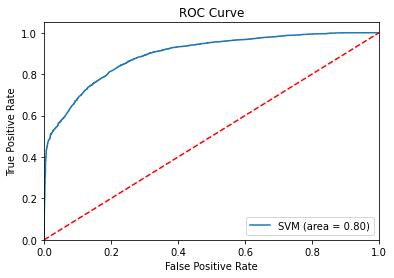

In [34]:
"""
The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away 
from that line as possible
"""
logit_roc_auc = roc_auc_score(y, y_pred)
fpr, tpr, thresholds = roc_curve(y, nn.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVM (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [35]:
#Final predictions on the test set to provide for submission
test_data = pd.read_csv("test.csv")
passenger_ids = test_data["PassengerId"]
test_data = preprocessingData(test_data)

test_data = pca.fit_transform(test_data)
test_data = test_data[:, :25]

y_pred=nn.predict(test_data) 

final_submission = pd.DataFrame()
final_submission["PassengerId"] = passenger_ids
final_submission["Transported"] = y_pred
final_submission.to_csv('NeuralNetworkSubmission.csv', index=False)
#Final Submission Produced an accuracy of 0.79214 on the test set